In [350]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation

#%matplotlib nbagg
%matplotlib inline

import tensorflow as tf
import os

In [275]:
def reset_graph(seed=None):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [276]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch, 

def plot_animation(frames, repeat=False, interval=40):
    plt.close()
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), 
                                   frames=len(frames), repeat=repeat,interval=interval)

#### Policy Search

In [3]:
# create environment: CartPole
env = gym.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [25]:
# reset the state of the environment -> return an initial observation
obs = env.reset()

In [26]:
# [horizontal position, horizontal velocity, angle of the pole, angular velocity]
print(obs)

[0.04105138 0.01746733 0.01770428 0.04570683]


In [6]:
#env.render()

In [7]:
env.action_space

Discrete(2)

In [27]:
action = 1   #accelerate right
obs, reward, done, info = env.step(action)

In [29]:
obs, reward, done, info

(array([ 0.04140072,  0.21233099,  0.01861841, -0.24133808]), 1.0, False, {})

In [53]:
# hardcode a simple policy
def basic_policy(obs):
    # accelerate left if the pole lean toward the left or vice versa
    angle = obs[2]
    return 0 if angle < 0 else 1

def display_cartpole(env):
    plt.imshow(env.render(mode='rgb_array'))
    
def render_cartpole(env):
    return env.render(mode='rgb_array')

In [57]:
# run 500 episodes, each with maximum 1000 steps
total = []
for i in range(500):
    # restart the environment
    obs = env.reset()
    total_reward = 0
    for j in range(1000):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        if done:
            break
    total.append(total_reward)

In [58]:
np.mean(total), np.std(total), np.min(total), np.max(total)

(42.96, 8.733292620770245, 24.0, 72.0)

In [4]:
obs = env.reset()
img = env.render(mode='rgb_array')

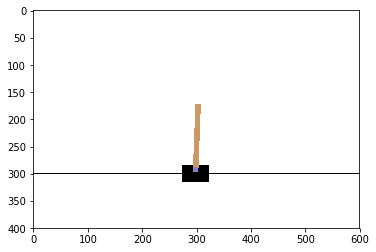

In [5]:
plt.imshow(img)

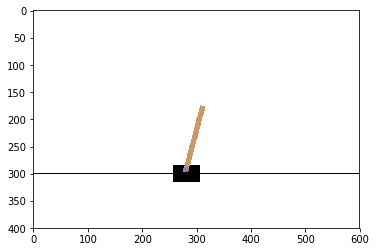

In [6]:
obs, reward, done, info = env.step(action=0)
while not done:
    obs, reward, done, info = env.step(action=0)
    plt.imshow(env.render(mode='rgb_array'))

#### Neural Network Policies

In [33]:
def discount_reward(rewards, discount_rate):
    '''create an array of discounted reward from an array of rewards 
    with the given discount rate'''
    discount_reward = np.zeros_like(rewards)
    cumulative_reward = 0
    for i in reversed(range(len(rewards))):
        cumulative_reward = rewards[i] + discount_rate*cumulative_reward
        discount_reward[i] = cumulative_reward
    return discount_reward

def discount_and_normalize_rewards(all_rewards, discount_rate):
    '''
    params
    ------
    all_rewards : a list of arrays
            each array contains consecutive rewards from one game
    
    return
    ------
    normalize_rewards : a list of arrays
            each array contains normalized discounted rewards for each game
    '''
    all_discounted = [discount_reward(rewards, discount_rate) for rewards in all_rewards]
    flat_reward = np.concatenate(all_discounted)
    mean_reward = np.mean(flat_reward)
    std_reward = np.std(flat_reward)
    return [(rewards - mean_reward) / std_reward for rewards in all_discounted]

In [31]:
discount_reward([10, 0, -50], .8)

array([-22, -40, -50])

In [34]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], .8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [35]:
reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1
discount_rate = .95
learning_rate = .01

he_init = tf.variance_scaling_initializer()

X = tf.placeholder(shape=(None, n_inputs), dtype=tf.float32, name='X')
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, 
                         kernel_initializer=he_init, name='hidden')
logits = tf.layers.dense(hidden, n_outputs, activation=None, 
                         kernel_initializer=he_init, name='logits')

output = tf.nn.sigmoid(logits)  # p-left
p_left_or_right = tf.concat(axis=1, values=[output, 1-output])
action = tf.multinomial(tf.log(p_left_or_right), num_samples=1)

# loss: assume y is the right actions
y = 1. - tf.to_float(action)   # left[action->0, logit->1], right[action-1, logit->0]
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y)

optimizer = tf.train.AdamOptimizer(learning_rate)

grads_and_vars = optimizer.compute_gradients(xentropy)
# create placeholder for each variable -> to update gradient after applying Policy Gradients
grads = [grad for grad, _ in grads_and_vars]
grads_holder_vars = []
grad_placeholder = []
for grad, var in grads_and_vars:
    grad_holder = tf.placeholder(shape=grad.get_shape(), dtype=tf.float32)
    grad_placeholder.append(grad_holder)
    grads_holder_vars.append((grad_holder, var))

train_op = optimizer.apply_gradients(grads_holder_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [70]:
# performance before training
max_steps = 1000
frames = []
with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for i in range(max_steps):
        frames.append(render_cartpole(env))
        action_val = action.eval(feed_dict={X:np.reshape(obs, (1, -1))})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

<IPython.core.display.Javascript object>


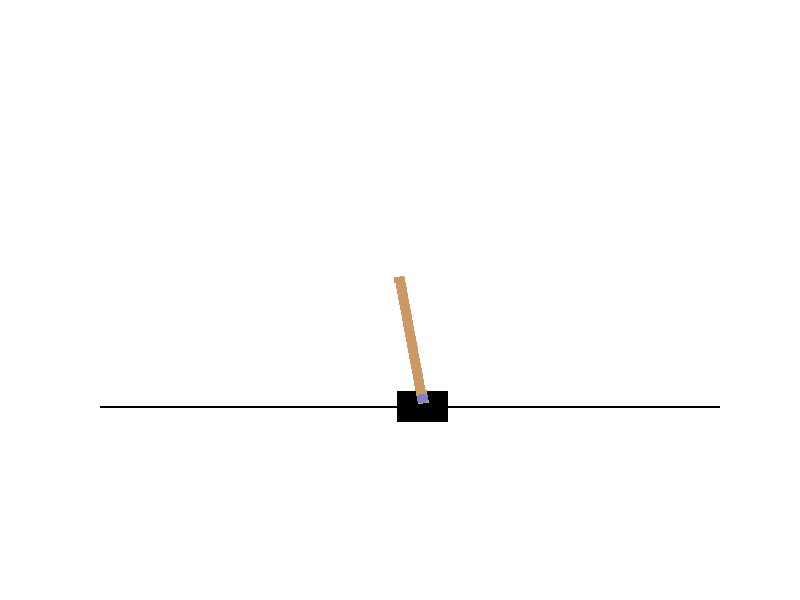

In [71]:
vdo = plot_animation(frames)
plt.show()

In [83]:
model_path = None

In [84]:
n_iterations = 700       # number of training iterations
n_max_steps = 1000       # max steps per episode
n_game_per_update = 10   # train the policy every 10 episodes
save_iteration = 10      # save model every 10 iterations
discount_rate = .95

with tf.Session() as sess:
    if model_path is not None:
        saver.restore(sess, model_path)
    else:
        init.run()
    for epoch in range(n_iterations):
        all_rewards = []       # shape: n_games, n_steps
        all_gradients = []     # shape: n_games, n_steps, n_vars
        for game in range(n_game_per_update):         
            # restart a new game
            obs = env.reset()
            current_rewards = []        # shape: n_steps
            current_gradients = []      # shape: n_steps, n_vars
            for step in range(n_max_steps):
                action_val, grads_val = sess.run([action, grads], feed_dict={X: np.reshape(obs, (1, -1))})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(grads_val)
                if done:
                    break
            # gather results from each game
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
        # compute mean grads of each var and update the policy
        norm_all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
        feed_dict = {}
        for var_idx, grad_holder in enumerate(grad_placeholder):
            mean_grad = np.mean([reward * all_gradients[game_idx][step_idx][var_idx]
                                for game_idx, rewards in enumerate(norm_all_rewards)
                                 for step_idx, reward in enumerate(rewards)], axis=0)
            feed_dict[grad_holder] = mean_grad
        sess.run(train_op, feed_dict=feed_dict)
        
        if epoch%save_iteration==0:
            print('saving model at epoch:', epoch)
            model_path = saver.save(sess, './my_policy_cartpole_nn.ckpt')

saving model at epoch: 0
saving model at epoch: 10
saving model at epoch: 20
saving model at epoch: 30
saving model at epoch: 40
saving model at epoch: 50
saving model at epoch: 60
saving model at epoch: 70
saving model at epoch: 80
saving model at epoch: 90
saving model at epoch: 100
saving model at epoch: 110
saving model at epoch: 120
saving model at epoch: 130
saving model at epoch: 140
saving model at epoch: 150
saving model at epoch: 160
saving model at epoch: 170
saving model at epoch: 180
saving model at epoch: 190
saving model at epoch: 200
saving model at epoch: 210
saving model at epoch: 220
saving model at epoch: 230
saving model at epoch: 240
saving model at epoch: 250
saving model at epoch: 260
saving model at epoch: 270
saving model at epoch: 280
saving model at epoch: 290
saving model at epoch: 300
saving model at epoch: 310
saving model at epoch: 320
saving model at epoch: 330
saving model at epoch: 340
saving model at epoch: 350
saving model at epoch: 360
saving model

In [72]:
def cartpole_frames(model_path, action, X, max_steps=1000):
    frames = []
    env = gym.make('CartPole-v0')
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for i in range(max_steps):
            frames.append(render_cartpole(env))
            action_val = action.eval(feed_dict={X:np.reshape(obs, (1, -1))})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

In [86]:
frames = cartpole_frames(model_path, action, X)
print(len(frames))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./my_policy_cartpole_nn.ckpt
200


<IPython.core.display.Javascript object>


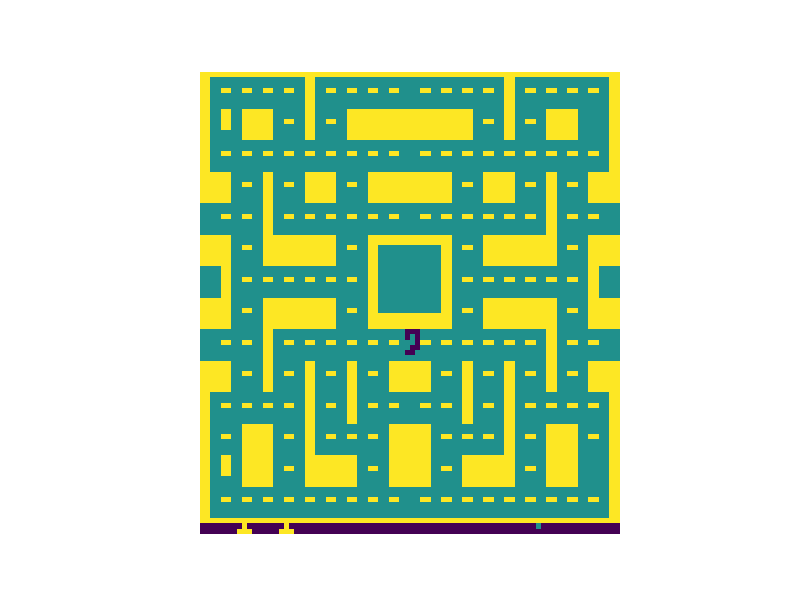

In [87]:
vdo = plot_animation(frames)
plt.show()

#### Markov Decision Processes

In [96]:
from numpy import nan

In [102]:
# Transition prob: [s, a, sp]  3,3,3
T = np.array([
    [[.7,.3,0.],[1.,0.,0.],[.8,.2,0.]],
    [[0.,1.,0.],[nan,nan,nan],[0.,0.,1.]],
    [[nan,nan,nan],[.8,.1,.1],[nan,nan,nan]]
])

# Reward: [s, a, sp]
R = np.array([
    [[10.,0.,0.],[0.,0.,0.],[0.,0.,0.]],
    [[0.,0.,0.],[nan,nan,nan],[0.,0.,-50.]],
    [[nan,nan,nan],[40.,0.,0.],[nan,nan,nan]]
])

possible_actions = [[0, 1, 2], [0, 2], [1]]   # [s][a]

# Q-value matrix: shape[s, a]
Q = np.full(shape=(3, 3), fill_value=-np.inf)

# initialize Q-value to 0 for all possible (s,a) pairs
for s in range(len(possible_actions)):
    for a in possible_actions[s]:
        Q[s, a] = 0.
        
discount_rate = .95
n_iters = 1000
for i in range(n_iters):
    Q_prev = np.copy(Q)
    for s in range(len(possible_actions)):
        for a in possible_actions[s]:
            Q[s, a] = np.sum([
                T[s,a,sp]*(R[s,a,sp] + discount_rate*np.max(Q_prev[sp])) 
                    for sp in range(len(possible_actions))
            ])

In [103]:
Q

array([[21.89925005, 20.80428755, 16.86759588],
       [ 1.12082922,        -inf,  1.17982024],
       [       -inf, 53.87349498,        -inf]])

In [105]:
np.argmax(Q, axis=1)

array([0, 2, 1], dtype=int64)

In [126]:
# off-policy algorithm
learning_rate0 = .05
learning_rate_decay = .1
n_iters = 20000

# init state
s = 0

Q = np.full((3, 3), -np.inf)
for s, actions in enumerate(possible_actions):
    Q[s, actions] = 0.
    
for i in range(n_iterations):
    # random a and sp from current state
    a = np.random.choice(possible_actions[s])
    sp = np.random.choice(range(3), p=T[s, a])
    reward = R[s, a, sp]
    learning_rate = learning_rate0/(1 + learning_rate_decay*i)
    Q[s, a] = learning_rate*Q[s, a] + (1-learning_rate)*(reward + discount_rate*np.max(Q[sp]))
    s = sp

In [127]:
Q

array([[146.67703899, 139.34130534, 139.34316636],
       [ 97.94193659,         -inf, 112.36359195],
       [        -inf, 170.9230038 ,         -inf]])

In [128]:
np.argmax(Q, axis=1)

array([0, 2, 1], dtype=int64)

#### Learning to Play Ms.Pac-Man Using Deep Q-Learning
* pip install --no-index -f https://github.com/Kojoley/atari-py/releases atari_py

In [155]:
env = gym.make('MsPacman-v0')
obs = env.reset()

In [156]:
obs.shape

(210, 160, 3)

In [133]:
env.action_space

Discrete(9)

In [147]:
%matplotlib inline

In [172]:
mspacman_color = np.array([210, 164, 74]).sum()

def preprocess_observation(obs):
    img = obs[1:176:2, ::2]     # crop and downsize
    img = img.sum(axis=2)      # to greyscale
    img[img==mspacman_color] = 0   # improve contrast
    img = (img/3 - 128)   # normalize from -128 to 127
    return img.reshape(88, 80, 1).astype(np.int8)

(-0.5, 79.5, 87.5, -0.5)

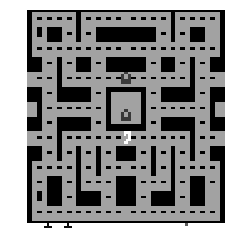

In [170]:
plt.imshow(preprocess_observation(obs), cmap=plt.cm.gray_r)
plt.axis('off')

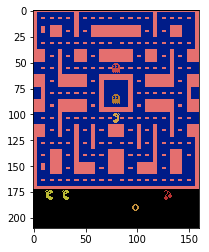

In [157]:
plt.imshow(obs)

In [260]:
reset_graph()

input_H, input_W, input_C = 88, 80, 1
kernel_sizes = [(8,8), (4,4), (3,3)]
strides = [4, 2, 1]
filters = [32, 64, 64]
paddings = ['SAME'] * 3
activations = [tf.nn.relu] * 3
n_hidden_in = 11*10*64
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n

he_init = tf.variance_scaling_initializer()

def q_network(X_state, scope):
    conv_layers = []
    prev_layer = X_state
    with tf.variable_scope(scope) as scope:
        for channel, stride, kernel, pad, activation in zip(filters, strides, 
                                                           kernel_sizes, paddings, 
                                                           activations):
            prev_layer = tf.layers.conv2d(prev_layer, channel, kernel, stride, pad, 
                                          activation=activation, kernel_initializer=he_init)
            conv_layers.append(prev_layer)
        hidden_flat = tf.reshape(prev_layer, shape=(-1, n_hidden_in))
        hidden = tf.layers.dense(hidden_flat, n_hidden, activation=hidden_activation, 
                                 kernel_initializer=he_init)
        outputs = tf.layers.dense(hidden, n_outputs, activation=None, kernel_initializer=he_init)
        train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
        train_vars_by_name = {var.name[len(scope.name):]:var for var in train_vars}
    return outputs, train_vars_by_name

X_state = tf.placeholder(shape=(None, input_H, input_W, input_C), dtype=tf.float32)
actor_q_values, actor_vars = q_network(X_state, scope='q_networks/actor')
critic_q_values, critic_vars = q_network(X_state, scope='q_networks/critic')

copy_ops = [actor_var.assign(critic_vars[var_name]) 
            for var_name, actor_var in actor_vars.items()]
copy_critic_to_actor = tf.group(*copy_ops)

In [261]:
# critic DQN training
learning_rate = .001

X_action = tf.placeholder(shape=[None], dtype=tf.int32)
q_value = tf.reduce_sum(critic_q_values*tf.one_hot(X_action, n_outputs), 
                        keepdims=True, axis=1)

y = tf.placeholder(shape=[None, 1], dtype=tf.float32)     # target Q-values
error = tf.abs(y - q_value)
clipped_error = tf.clip_by_value(error, 0., 1.)
linear_error = 2*(error - clipped_error)
cost = tf.reduce_mean(tf.square(clipped_error) + linear_error)

global_step = tf.Variable(0, trainable=False, name='global_step')
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cost, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [195]:
class ReplayMemory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buff = np.empty(max_size, dtype=np.object)
        self.index = 0
        self.length = 0
    
    def append(self, data):
        self.buff[self.index] = data
        self.length = min(self.max_size, self.length+1)
        self.index = (self.index + 1) % self.max_size
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            idx = np.random.randint(0, self.length, batch_size)
        else:
            idx = np.random.permutation(self.length)[:batch_size]
        return self.buff[idx]

In [244]:
def sample_memories(batch_size):
    # each data = [state, action, reward, next_state, continue]
    cols = [[], [], [], [], []]
    for memory in replay_memory.sample(batch_size):
        for col, val in zip(cols, memory):
            col.append(val)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [198]:
eps_min = .05
eps_max = 1.0
eps_decay_steps = 50000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min)*step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    return np.argmax(q_values)               # optimal action

In [268]:
n_steps = 1000000        # total number of training steps
training_start = 1000   # 1000 step warmup before training 
training_interval = 3   # training every 3 game iterations
save_steps = 50
copy_steps = 20
discount_rate = .95
skip_start = 90         # waiting time before pacman really start
batch_size = 50
iteration = 0           # game iteration
checkpoint_path = './my_dqn.ckpt'
done = True             # whether need to restart a game

replay_memory_size = 10000
replay_memory = ReplayMemory(replay_memory_size)

In [269]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + '.index'):
        saver.restore(sess, checkpoint_path)    # continue training
    else:
        init.run()      # a new training
    while True:
        
        # pacman environment
        step = global_step.eval()
        if iteration%50000==0:
            print('step:', step)
        if step > n_steps:
            break
        iteration += 1
        if done:
            obs = env.reset()
            for _ in range(skip_start):
                obs, reward, done, info = env.step(0)    # skip waiting time
            state = preprocess_observation(obs)
        
        # actor decide what to do
        q_values = actor_q_values.eval(feed_dict={X_state:[state]})
        action = epsilon_greedy(q_values, step)
        
        # actor perform
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)
        
        # keep memory
        replay_memory.append((state, action, reward, next_state, 1.0-done))
        state = next_state
        
        if (iteration < training_start) or (iteration % training_interval != 0):
            continue
        
        # critic learn
        # sampling memories
        X_state_val, X_action_val, rewards, X_next_state_val, continues = sample_memories(batch_size)
        next_q_values = actor_q_values.eval(feed_dict={X_state:X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values
        training_op.run(feed_dict={X_state: X_state_val, 
                                   X_action:X_action_val, y:y_val})
        
        # copy critic params
        if step % copy_steps == 0:
            copy_critic_to_actor.run()
            
        # save model
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

step: 0
step: 16333
step: 33000
step: 49667
step: 66333
step: 83000
step: 99667
step: 116333
step: 133000
step: 149667
step: 166333
step: 183000
step: 199667
step: 216333
step: 233000
step: 249667
step: 266333
step: 283000
step: 299667
step: 316333
step: 333000
step: 349667
step: 366333
step: 383000
step: 399667
step: 416333
step: 433000
step: 449667
step: 466333
step: 483000
step: 499667
step: 516333
step: 533000
step: 549667
step: 566333
step: 583000
step: 599667
step: 616333
step: 633000
step: 649667
step: 666333
step: 683000
step: 699667
step: 716333
step: 733000
step: 749667
step: 766333
step: 783000
step: 799667
step: 816333
step: 833000
step: 849667
step: 866333
step: 883000
step: 899667
step: 916333
step: 933000
step: 949667
step: 966333
step: 983000
step: 999667


In [271]:
frames = []
n_frames = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    obs = env.reset()
    
    for _ in range(skip_start):
        obs, _, _, _ = env.step(0)
    
    for i in range(n_frames):
        frames.append(env.render(mode='rgb_array'))
        
        state = preprocess_observation(obs)
        q_values = actor_q_values.eval(feed_dict={X_state:[state]})
        action = np.argmax(q_values)
        obs, reward, done, info = env.step(action)
        if done:
            break

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


<IPython.core.display.Javascript object>


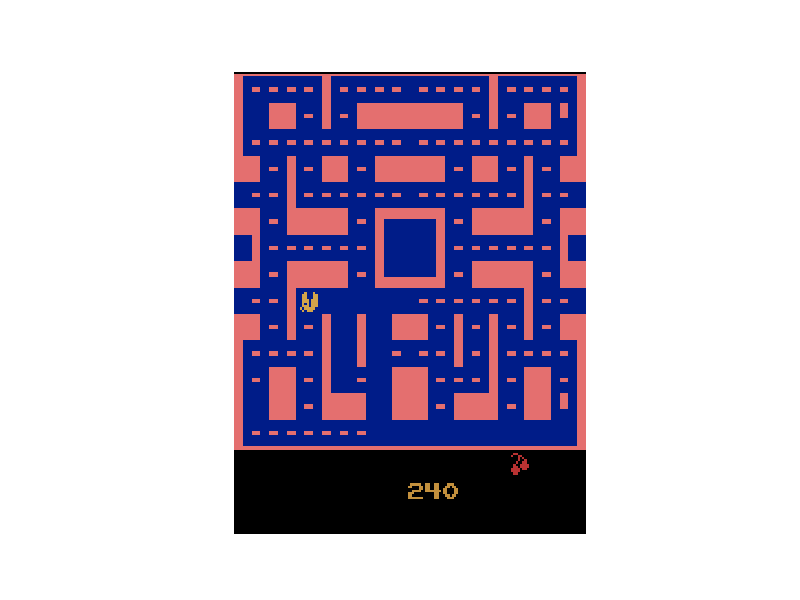

In [273]:
plot_animation(frames)

####  Breakout-atari

In [316]:
def preprocess_breakout(obs):
    img = obs[34:194:2, ::2]    # cropping
    img = img.mean(axis=2)      # grey image
    img = img.reshape(80, 80)   # reshape
    return (img / 255.).astype(np.float32)



In [319]:
env = gym.make('Breakout-v0')

In [320]:
obs = env.reset()

In [321]:
img = env.render(mode='rgb_array')
img_preprocess = preprocess_breakout(img)

<IPython.core.display.Javascript object>


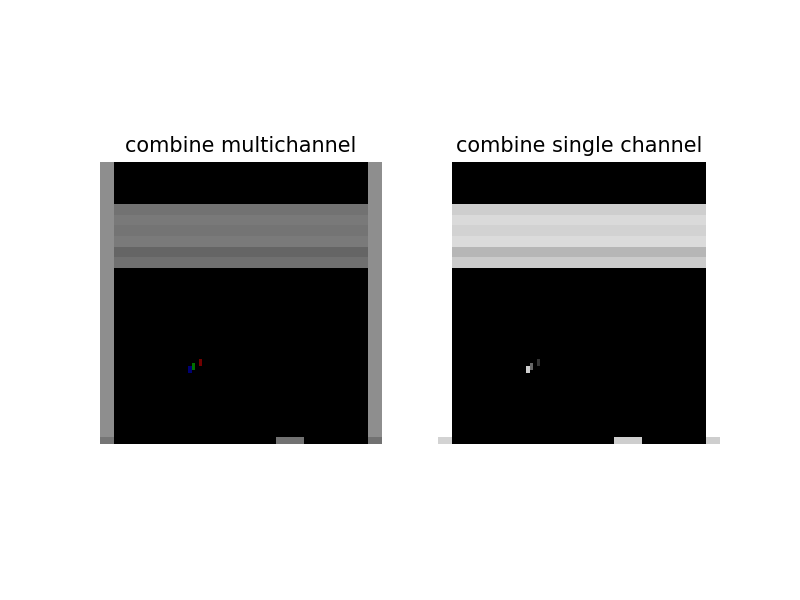

(-0.5, 79.5, 79.5, -0.5)

In [325]:
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original -  shape:{}'.format(img.shape))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_preprocess, cmap=plt.cm.gray)
plt.title('Preprocessed - shape:{}'.format(img_preprocess.shape))
plt.axis('off')

In [338]:
from collections import deque

In [340]:
n_observations_per_state = 3
preprocessed_observations = deque([], maxlen=n_observations_per_state)

In [348]:
def combine_observations_multichannel(preprocessed_observations):
    '''
    input: deque, n observations each shape[H, W]
    output: shape[H, W, n]
    '''
    return np.array(preprocessed_observations).transpose([1,2,0])

def combine_observations_singlechannel(preprocessed_observations, dim_factor=0.5):
    '''
    input: deque, n observations each shape[H, W]
    output: an array shape{H, W}
    '''
    dim_preprocessed = np.array([obs*(dim_factor**i) 
                                for i, obs in enumerate(reversed(preprocessed_observations))])
    return np.max(dim_preprocessed, axis=0)

In [343]:
obs = env.reset()
for _ in range(10):
    obs, _, _, _ = env.step(1)
    preprocessed_observations.append(preprocess_breakout(obs))

(-0.5, 79.5, 79.5, -0.5)

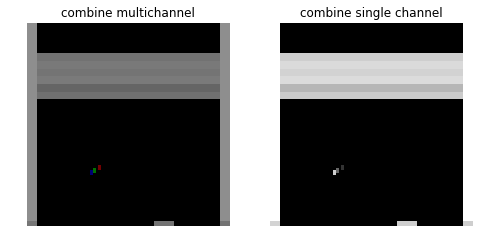

In [352]:
img1 = combine_observations_multichannel(preprocessed_observations)
img2 = combine_observations_singlechannel(preprocessed_observations)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('combine multichannel')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap=plt.cm.gray)
plt.title('combine single channel')
plt.axis('off')

#### bipedal walker

In [355]:
#env = gym.make("BipedalWalker-v2")

In [356]:
from itertools import product

In [360]:
actions = np.array([1., 0, -1.])
possible_actions = np.array(list(product(actions, actions, actions, actions)))

In [362]:
possible_actions.shape

(81, 4)